# 1. Environment Setup & Imports

In [1]:
import re
import string
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedShuffleSplit
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    DistilBertConfig,
    get_scheduler
)
import optuna

In [2]:
# Set reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

# 2. Data Loading and Preprocessing

In [15]:
def load_and_preprocess_data():
    df = pd.read_csv('all_it_jobs2.csv')
    columns_to_keep = ['review_text', 'sentiment']
    df = df[columns_to_keep].dropna(subset=['review_text'])
    
    label_map = {"Negative": 0, "Neutral": 1, "Positive": 2}
    df['label'] = df['sentiment'].map(label_map)
    
    # Sampling 500 per sentiment (with replacement)
    df_sampled = (df.groupby("sentiment")
                  .sample(n=1000, random_state=SEED, replace=True)
                  .reset_index(drop=True))
    
    print("=== Sample reviews (raw) ===")
    print(df_sampled['review_text'].head(3).to_list())
    
    # Enhanced text cleaning: lowercase, remove URLs, punctuation, and extra spaces.
    def clean_text(text):
        text = str(text).lower()
        text = re.sub(r'http\S+|www\S+', '', text)
        text = re.sub(r'[{}]'.format(re.escape(string.punctuation)), '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    df_sampled['cleaned_review'] = df_sampled['review_text'].apply(clean_text)
    print("\n=== Sample reviews (cleaned) ===")
    print(df_sampled['cleaned_review'].head(3).to_list())
    return df_sampled


df_sampled = load_and_preprocess_data()

=== Sample reviews (raw) ===
["**Company To AVOID** Disgusting management, 0 structure in the company, toxic CEO Remote working ( and when you start to know the boss, you understand why it's better like that ) The CEO. Certified bad boss, I invite you to do research on the guy and you'll understand the pattern, it's not his first company that crash because of big turnover and inexistent customer support. He's known by lawyers in Tel Aviv as much as his employees attack him in court. Strictly no opportunity for growth in this company, and the pay is anyway not attractive with no more than 12 days of holidays a year. He still didn't pay me the pension that he owe me. Real lunatic , you'll need a lot of patience and self control to handle the Ceo", 'Software engineer Immense opportunity to learn and ownership of projects end to end No work life balance and no wfh options and 45hrs/week strict criteria', 'Not a very good environment to work 1. transport is good\r\n2. food provided by compa

# 3. Tokenization (Global Initialization)

In [16]:
# Initialize the tokenizer once for efficiency.
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_data(df, max_length=256):
    return tokenizer(
        text=df['cleaned_review'].tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt',
        add_special_tokens=True,
        return_attention_mask=True,
        return_token_type_ids=False
    )

# Tokenize the sampled data
tokenized = tokenize_data(df_sampled)
input_ids = tokenized['input_ids']
attention_mask = tokenized['attention_mask']
labels = torch.tensor(df_sampled['label'].values, dtype=torch.long)

# 4. Stratified Data Splitting


In [17]:
def stratified_split(inputs, masks, labels, test_size=0.3):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=SEED)
    train_idx, temp_idx = next(sss.split(inputs, labels))
    return (inputs[train_idx], masks[train_idx], labels[train_idx]), \
           (inputs[temp_idx], masks[temp_idx], labels[temp_idx])

# Split data into train, validation, and test sets
(train_inputs, train_masks, train_labels), (temp_inputs, temp_masks, temp_labels) = stratified_split(input_ids, attention_mask, labels)
(val_inputs, val_masks, val_labels), (test_inputs, test_masks, test_labels) = stratified_split(temp_inputs, temp_masks, temp_labels, test_size=0.5)

# 5. DataLoader Utility

In [18]:
def create_dataloader(inputs, masks, labels, batch_size, shuffle=False):
    return DataLoader(
        TensorDataset(inputs, masks, labels),
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=4,
        pin_memory=True,
        prefetch_factor=2
    )

# 6. Validation and Evaluation Functions

In [19]:
def validate(model, val_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad(), torch.autocast(device_type='cuda', dtype=torch.float16):
        for batch in val_loader:
            inputs, masks, lbls = [t.to(device, non_blocking=True) for t in batch]
            logits = model(inputs, attention_mask=masks).logits
            preds = logits.argmax(dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(lbls.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    return acc, f1, precision, recall

In [20]:
def evaluate_with_metrics(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad(), torch.autocast(device_type='cuda', dtype=torch.float16):
        for batch in test_loader:
            inputs, masks, lbls = [t.to(device, non_blocking=True) for t in batch]
            logits = model(inputs, attention_mask=masks).logits
            preds = logits.argmax(dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(lbls.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    return cm, acc, f1, precision, recall

# 7. Training Function with Mixed Precision

In [21]:
def optimized_train(model, train_loader, optimizer, scheduler, params, device):
    model.train()
    total_loss = 0
    scaler = torch.amp.GradScaler("cuda")
    optimizer.zero_grad()
    for step, batch in enumerate(tqdm(train_loader, desc="Training")):
        inputs, masks, lbls = [t.to(device, non_blocking=True) for t in batch]
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(inputs, attention_mask=masks, labels=lbls)
            loss = outputs.loss / params['grad_accum_steps']
        scaler.scale(loss).backward()
        if (step + 1) % params['grad_accum_steps'] == 0:
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), params['grad_clip'])
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()
        total_loss += loss.item() * params['grad_accum_steps']
    return total_loss / len(train_loader)

# 8. Hyperparameter Tuning with Optuna (Optional)

In [22]:
USE_OPTUNA = False  # Change to True to enable Optuna tuning

default_params = {
    'lr': 3e-5,
    'weight_decay': 1e-5,
    'num_epochs': 5,
    'hidden_dropout': 0.3,
    'attention_dropout': 0.3,
    'batch_size': 32,
    'grad_clip': 1.0,
    'grad_accum_steps': 1
}

def run_optuna(train_inputs, train_masks, train_labels, val_inputs, val_masks, val_labels, device):
    def objective(trial):
        params = {
            'lr': trial.suggest_float('lr', 1e-5, 5e-5, log=True),
            'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-4, log=True),
            'num_epochs': trial.suggest_int('num_epochs', 5, 10),
            'hidden_dropout': trial.suggest_float('hidden_dropout', 0.2, 0.4),
            'attention_dropout': trial.suggest_float('attention_dropout', 0.2, 0.4),
            'batch_size': trial.suggest_categorical('batch_size', [32, 64]),
            'grad_clip': trial.suggest_float('grad_clip', 0.5, 1.5),
            'grad_accum_steps': trial.suggest_int('grad_accum_steps', 1, 2)
        }
        print(f"\n--- Starting trial with params: {params} ---")
        train_loader = create_dataloader(train_inputs, train_masks, train_labels, params['batch_size'], shuffle=True)
        val_loader = create_dataloader(val_inputs, val_masks, val_labels, params['batch_size'])
        
        config = DistilBertConfig.from_pretrained(
            'distilbert-base-uncased',
            num_labels=3,
            hidden_dropout_prob=params['hidden_dropout'],
            attention_probs_dropout_prob=params['attention_dropout']
        )
        model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config).to(device)
        
        optimizer = optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        total_steps = (len(train_loader) // params['grad_accum_steps']) * params['num_epochs']
        scheduler = get_scheduler('linear', optimizer, num_warmup_steps=int(total_steps * 0.1), num_training_steps=total_steps)
        scaler = torch.amp.GradScaler(device_type='cuda')
        
        best_f1 = 0
        for epoch in range(params['num_epochs']):
            model.train()
            optimizer.zero_grad()
            for step, batch in enumerate(train_loader):
                inputs, masks, lbls = [t.to(device, non_blocking=True) for t in batch]
                with torch.autocast(device_type='cuda', dtype=torch.float16):
                    outputs = model(inputs, attention_mask=masks, labels=lbls)
                    loss = outputs.loss / params['grad_accum_steps']
                scaler.scale(loss).backward()
                if (step + 1) % params['grad_accum_steps'] == 0:
                    scaler.unscale_(optimizer)
                    nn.utils.clip_grad_norm_(model.parameters(), params['grad_clip'])
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    scheduler.step()
            acc, f1, _, _ = validate(model, val_loader, device)
            print(f"Trial {trial.number}, Epoch {epoch+1}/{params['num_epochs']} - Val Acc: {acc:.4f}, Val F1: {f1:.4f}")
            trial.report(f1, epoch)
            if trial.should_prune():
                print("Trial pruned!")
                raise optuna.TrialPruned()
            best_f1 = max(best_f1, f1)
        print(f"Trial {trial.number} finished with best validation F1: {best_f1:.4f}")
        return best_f1

    study = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=SEED),
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=1)
    )
    study.optimize(objective, n_trials=20, n_jobs=1, show_progress_bar=True)
    best_params = study.best_params.copy()
    print("\nBest Hyperparameters Found:")
    print(best_params)
    return best_params

# 9. Final Training with Best Parameters

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# (Re)load and preprocess data
df_sampled = load_and_preprocess_data()
tokenized = tokenize_data(df_sampled)
input_ids = tokenized['input_ids']
attention_mask = tokenized['attention_mask']
labels = torch.tensor(df_sampled['label'].values, dtype=torch.long)

# Stratified split
(train_inputs, train_masks, train_labels), (temp_inputs, temp_masks, temp_labels) = stratified_split(input_ids, attention_mask, labels)
(val_inputs, val_masks, val_labels), (test_inputs, test_masks, test_labels) = stratified_split(temp_inputs, temp_masks, temp_labels, test_size=0.5)

# Choose hyperparameters
if USE_OPTUNA:
    best_params = run_optuna(train_inputs, train_masks, train_labels, val_inputs, val_masks, val_labels, device)
else:
    best_params = default_params
    print("\nUsing default hyperparameters:")
    print(best_params)

# Prepare DataLoaders
train_loader = create_dataloader(train_inputs, train_masks, train_labels, best_params['batch_size'], shuffle=True)
val_loader = create_dataloader(val_inputs, val_masks, val_labels, best_params['batch_size'])
test_loader = create_dataloader(test_inputs, test_masks, test_labels, best_params['batch_size'])

# Final model initialization
config = DistilBertConfig.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3,
    hidden_dropout_prob=best_params['hidden_dropout'],
    attention_probs_dropout_prob=best_params['attention_dropout']
)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config).to(device)

optimizer = optim.AdamW(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
total_steps = (len(train_loader) // best_params['grad_accum_steps']) * best_params['num_epochs']
scheduler = get_scheduler('linear', optimizer, num_warmup_steps=int(total_steps * 0.1), num_training_steps=total_steps)

# Training loop with early stopping based on F1 score
train_losses = []
val_accuracies = []
val_f1_scores = []
best_val_f1 = 0
patience_counter = 0

for epoch in range(best_params['num_epochs']):
    train_loss = optimized_train(model, train_loader, optimizer, scheduler, best_params, device)
    train_losses.append(train_loss)
    
    acc, f1, _, _ = validate(model, val_loader, device)
    val_accuracies.append(acc)
    val_f1_scores.append(f1)
    
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Acc = {acc:.4f}, Val F1 = {f1:.4f}")
    
    if f1 > best_val_f1:
        best_val_f1 = f1
        patience_counter = 0
        torch.save(model.state_dict(), 'best_uncased_bert_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= 3:
            print("Early stopping triggered")
            break

Using device: cuda
=== Sample reviews (raw) ===
["**Company To AVOID** Disgusting management, 0 structure in the company, toxic CEO Remote working ( and when you start to know the boss, you understand why it's better like that ) The CEO. Certified bad boss, I invite you to do research on the guy and you'll understand the pattern, it's not his first company that crash because of big turnover and inexistent customer support. He's known by lawyers in Tel Aviv as much as his employees attack him in court. Strictly no opportunity for growth in this company, and the pay is anyway not attractive with no more than 12 days of holidays a year. He still didn't pay me the pension that he owe me. Real lunatic , you'll need a lot of patience and self control to handle the Ceo", 'Software engineer Immense opportunity to learn and ownership of projects end to end No work life balance and no wfh options and 45hrs/week strict criteria', 'Not a very good environment to work 1. transport is good\r\n2. foo

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.9670, Val Acc = 0.6333, Val F1 = 0.6363


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.6979, Val Acc = 0.6600, Val F1 = 0.6621


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.5425, Val Acc = 0.6667, Val F1 = 0.6694


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 4: Train Loss = 0.4146, Val Acc = 0.6867, Val F1 = 0.6891


Training:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 5: Train Loss = 0.3228, Val Acc = 0.6733, Val F1 = 0.6749


# 10. Plot Training Curves

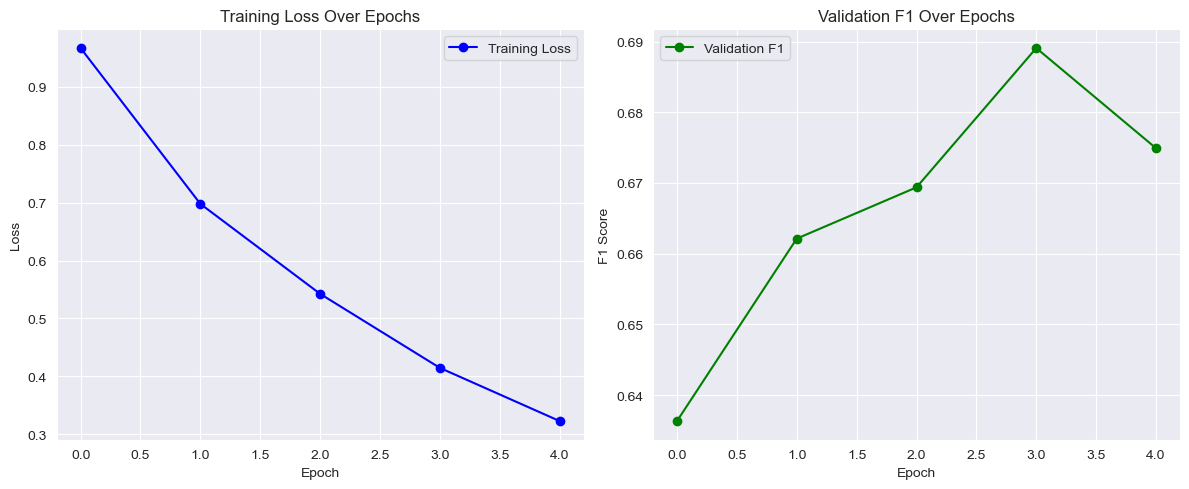

In [24]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_f1_scores, label='Validation F1', color='green', marker='o')
plt.title('Validation F1 Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

# 11. Final Evaluation and Visualization

C:\Users\KomPhone\AppData\Local\Temp\ipykernel_10508\870329772.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_uncased_bert_model.

Test Accuracy: 0.7333
Test Precision: 0.7425
Test Recall: 0.7333
Test F1 Score: 0.7364


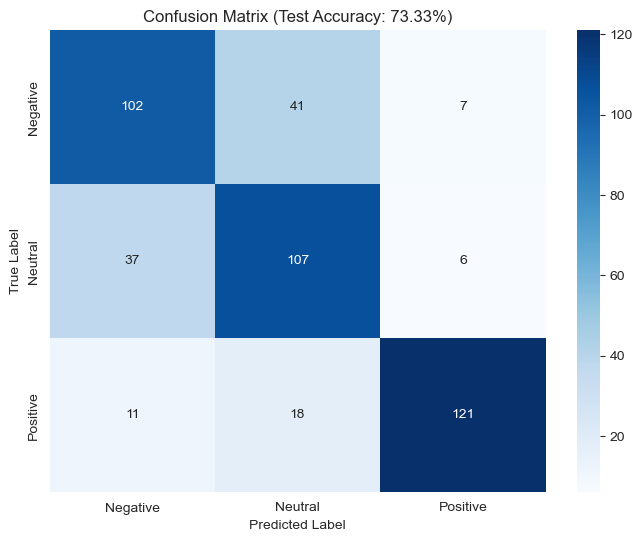

In [25]:
model.load_state_dict(torch.load('best_uncased_bert_model.pth'))
cm, test_acc, test_f1, test_precision, test_recall = evaluate_with_metrics(model, test_loader, device)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title(f'Confusion Matrix (Test Accuracy: {test_acc:.2%})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 12. Save Model and Tokenizer

In [14]:
#model.save_pretrained('best_uncased_bert_model')
#tokenizer.save_pretrained('best_uncased_bert_model')